In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

from jupyter_server import serverapp as app; 
import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [5]:
data_files

['../data/parameter_runs/many_kappas//01-10-19--04-06-2023abm_result_feather']

In [6]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [7]:
datadf['first_tb'].unique()

array([29.47310585, 20.68064554,         inf, ..., 10.84717367,
        5.99631146,  3.10555556])

In [8]:

@jit(nopython=True)
def p_surv(fit,t_lim,dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv
            

def product_sum_probas(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = p_surv(fit,t_lim, dt)
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

def product_sum_probas_adiabatic(S,I, t_lim, R0, kappa,xi,ds,dt, N, p_alpha):
    x,y = S/N, I/N
    z = 1-x-y
    
    fit_d = lambda d: R0/(1+y*kappa) * ( x + (1- np.exp(-d/xi))*z )-1

    product_sum = 0
    
    L = len(ds)
    for i in range(L):
        d= ds[i]
        fit = fit_d(d)
        p_surv_t = np.maximum(0,1 - 1/(1+fit))
        product_sum +=funcs.rho_d(d=d,p_alpha=p_alpha )*p_surv_t
    
    return product_sum

In [9]:


def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))

def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 3*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,10000)
    dt = ts[1]-ts[0]
    y = odeint(model_w_params(R0,N,kappa),y0,ts).T

    return ts, y

def get_exp_num_established(R0, kappa, p_alpha,xi, N,pbar = None):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)

    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    if pbar is not None:
        pbar.update(1)
    return exp_number_est_mutants

def get_exp_num_established_adiabatic(R0, kappa, p_alpha,xi, N):
    ts, solution= integrate_trajectory(R0,kappa,N)
    ds = np.arange(1,int(10/p_alpha)+1)

    S,I = solution
    t2 = ts[-1]
    dt = ts[1]-ts[0]
    idx_times = ts<t2
    prod_sum_prob = product_sum_probas_adiabatic(S,I, t2, R0, kappa,xi,ds,dt, N, p_alpha)
    try:
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
    except ValueError:
        idx_times = ts<=t2
        exp_number_est_mutants = dt*np.sum(prod_sum_prob*I[idx_times])
        
    return exp_number_est_mutants

In [10]:
R0 = 2.5
N = 1e8
mu_s = np.logspace(0,3,501, base =10)/N
kappa_s = np.concatenate([np.array([0]), np.logspace(0,3,21,base=10)])
dbar = 50
delta_s= np.logspace(-2,0,30, base =10)
xi_s= dbar/delta_s
R0s = np.logspace(np.log10(1.5),1,10)

if os.path.exists(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather'):
    exp_t_dep_nums_df_modulo_mu_mountain = pd.read_feather(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather')
else:
    pbar = tqdm(total = len(kappa_s)*len(xi_s)*len(R0s))
    exp_t_dep_nums_df_modulo_mu_mountain = pd.DataFrame.from_dict(
        {i:(R0, kappa,  N, dbar, xi,
            get_exp_num_established(R0=R0, kappa = kappa, p_alpha=1/dbar,xi = xi, N=N, pbar = pbar)) 
            for i, (R0,kappa,xi) 
            in enumerate(
                funcs.product(R0s, kappa_s, xi_s))
                }, orient='index', columns=['R0', 'kappa', 'N', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])
    exp_t_dep_nums_df_modulo_mu_mountain.to_feather(os.getcwd()+'/pickles/exp_t_dep_nums_df_modulo_mu_mountain_big_d.feather')

In [11]:
evolution_pd = pd.DataFrame(columns=['R0', 'kappa', 'N', 'mu', 'dbar', 'xi','exp_num_est_mutants_mod_mu'])

for mu in mu_s:
    evolution_pd = pd.concat([evolution_pd, exp_t_dep_nums_df_modulo_mu_mountain.assign(mu=mu)], ignore_index=True)
    
evolution_pd['exp_num_est_mutants'] = evolution_pd['exp_num_est_mutants_mod_mu']*evolution_pd['mu']
evolution_pd['p_evo']= 1- np.exp(-evolution_pd['exp_num_est_mutants'])
evolution_pd['scaled_dbar'] = evolution_pd['dbar']/evolution_pd['xi']
# evolution_pd['scaled_dbar'] = np.round(evolution_pd['scaled_dbar'].astype(float),1)
evolution_pd['muN'] = evolution_pd['mu']*evolution_pd['N']
evolution_pd['kappa_plot'] = 1 + evolution_pd['kappa']

In [12]:
# colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

# for R0 in R0s:
#     fig,ax= plt.subplots(1,2,figsize=(20,10))
#     plt.subplots_adjust(wspace=0.3)

#     delta_s_from_df = evolution_pd['scaled_dbar'].unique()
#     for scaled_dbar in delta_s_from_df:
#         mini_df = (evolution_pd
#             .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
#             .groupby(['kappa_plot', 'muN'])
#             .mean()
#             .reset_index())
        
#         muN_vals = mini_df['muN'].unique()
#         kappa_vals = mini_df['kappa_plot'].unique()
#         p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

#         C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
#         Cx, Cy = C.allsegs[0][0].T
#         ax[0].plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
#         ax[1].plot(Cx, Cy*scaled_dbar, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')

#     ax[0].set_xlim(ax[0].get_xlim()*np.array([.5,2]))
#     ax[1].set_xlim(ax[0].get_xlim())
#     ax[0].set_ylim(ax[0].get_ylim()*np.array([.5,2]))
#     ax[1].set_ylim(ax[1].get_ylim()*np.array([.5,2]))

#     for xi in xi_s:
#         delta = dbar/xi
        
#         p_alpha= 1/dbar
#         exp_val_kappa_inf = mu*N/(xi*p_alpha) * ((R0-1)/R0)**2 /2 # exp must be log 2
#         exp_val_kappa0 = mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) # exp must be log 2

#         equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha))
#         equal_proba_point_kappa_inf = np.log(2)/(((R0-1)/R0)**2 /2)*(xi*p_alpha)
#         # p_evo_kappa0 = 1- np.exp(-mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) )
#         ax[0].scatter(1,equal_proba_point_kappa0, marker='x', color=colors_scaled_dbar[delta],s=80)
#         ax[0].scatter(1.5*kappa_s[-1] ,equal_proba_point_kappa_inf, s=10, marker='o',color=colors_scaled_dbar[delta])


#     handles, labels= ax[0].get_legend_handles_labels()
#     handles = handles[::3]
#     labels = labels[::3]


#     ax[0].set_yscale('log')
#     ax[0].set_xscale('log')
#     ax[0].set_xlabel(r'')
#     ax[0].set_ylabel(r'')
#     ax[1].set_xlabel(r'')
#     ax[1].set_ylabel(r'')

#     ax[1].set_xscale('log')
#     ylogged = True 

#     if ylogged:
#         ax[1].set_yscale('log')

#     ax[0].set_ylim((1,2e3))
#     ax[1].set_ylim((1,90))

#     ax[1].legend(handles,labels, title= r'$\frac{\langle d\rangle}{\xi}$',loc=(1.01,0.1), fontsize=10)
#     # os.makedirs(os.getcwd()+'/figures', exist_ok=True)
#     # plt.savefig(os.getcwd()+f'/figures/phase_diagram_mountain_logy{ylogged}.pdf', bbox_inches='tight')

In [13]:
#import linalgerror

from scipy.linalg import LinAlgError

In [18]:
exponents_dataframe = pd.DataFrame(columns=['R0', 'scaled_dbar', 'A', 'alpha'])
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

fit_params = []
for R0 in R0s:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.4)

    delta_s_from_df = evolution_pd['scaled_dbar'].unique()
    for scaled_dbar in delta_s_from_df:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
 
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        rescaled_Cy = Cy*scaled_dbar
        rescaled_Cy = np.abs(rescaled_Cy - rescaled_Cy[-1])

        #fit Cx, rescaled_Cy to power law
        try:
            fit = np.polyfit(np.log(Cx)[:-1], np.log(rescaled_Cy)[:-1], 1)
            fit_fn = np.poly1d(fit)
            exponents_dataframe = exponents_dataframe.append({'R0':R0, 'scaled_dbar':scaled_dbar, 'A':np.exp(fit_fn[0]), 'alpha':fit_fn[1]}, ignore_index=True)
        except LinAlgError:
            continue
        except TypeError:
            continue            

    plt.close(fig)

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


In [15]:
exponents_dataframe['kappa_star'] = exponents_dataframe['A']**(-1/exponents_dataframe['alpha'])

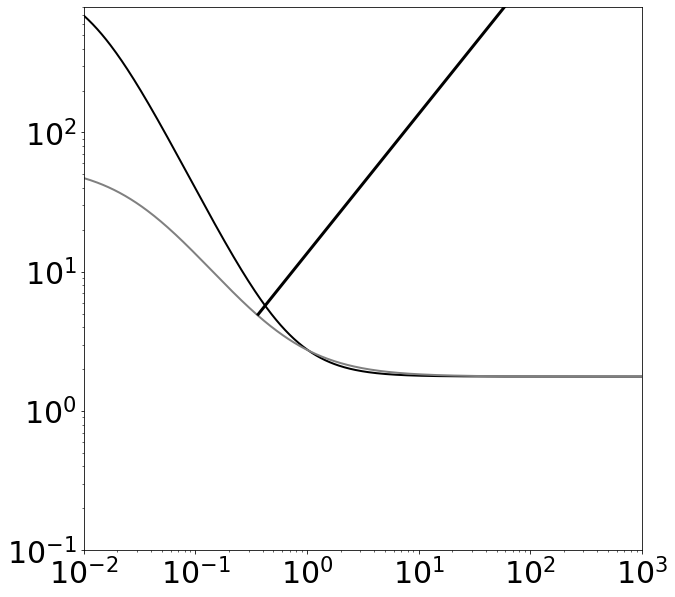

In [17]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)
delta_s_from_df = evolution_pd['scaled_dbar'].unique()
fig_ghost,ax_ghost = plt.subplots(1,1,figsize=(1,1))
plt.close(fig_ghost)
for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,1,figsize=(10,10))
    plt.subplots_adjust(wspace=0.3)
    
    for i_d, scaled_dbar in enumerate(delta_s_from_df[np.array([12, 16])]):
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
        C =ax_ghost.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        rescaled_Cy = Cy*scaled_dbar
        rescaled_Cy_subtracted = np.abs(rescaled_Cy - rescaled_Cy[-1]+1e-4)
    
        #fit Cx, rescaled_Cy to power law
        try:
            fit = np.polyfit(np.log(Cx[:-1]), np.log(rescaled_Cy_subtracted)[:-1], 1)
            fit_fn = np.poly1d(fit)
            exponent = fit_fn[1] 
        except LinAlgError:
            continue   

        kstar = (R0/(R0-1))**2 /scaled_dbar
        rescaled_Cx = Cx/kstar
        xs= np.logspace(-2,3,500)
        z_inf_inf = (R0-1)/R0
        if i_d ==0:
            color= 'k'
        else:
            color='grey'

        equal_proba_point_kappa_inf = np.log(2)/((-z_inf_inf-np.log(1-z_inf_inf)))#*delta_s_from_df)
        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-1/scaled_dbar))
        law = equal_proba_point_kappa_inf + (equal_proba_point_kappa0-equal_proba_point_kappa_inf)/( 1+  (equal_proba_point_kappa0-equal_proba_point_kappa_inf) *xs**(-exponent))
        ax.plot(xs, law , color=color, linestyle='-',lw=2)
    early_late_law =  2* R0**3/(R0-1)**2 * xs
    ax.plot(xs[early_late_law>=law],early_late_law[early_late_law>=law],color='black')

    ax.set_xscale('log')
    ylogged = True

    if ylogged:
        ax.set_yscale('log')
        ax.set_ylim(np.array([1e-1,8e2]))
        ax.set_xlim(np.array([1e-2,1e3]))
    else:
        ax.set_ylim((0,60))

# plt.savefig(output_folder+'/fig2.svg', bbox_inches='tight')

(1.127138741977637e-11, 10000.0)

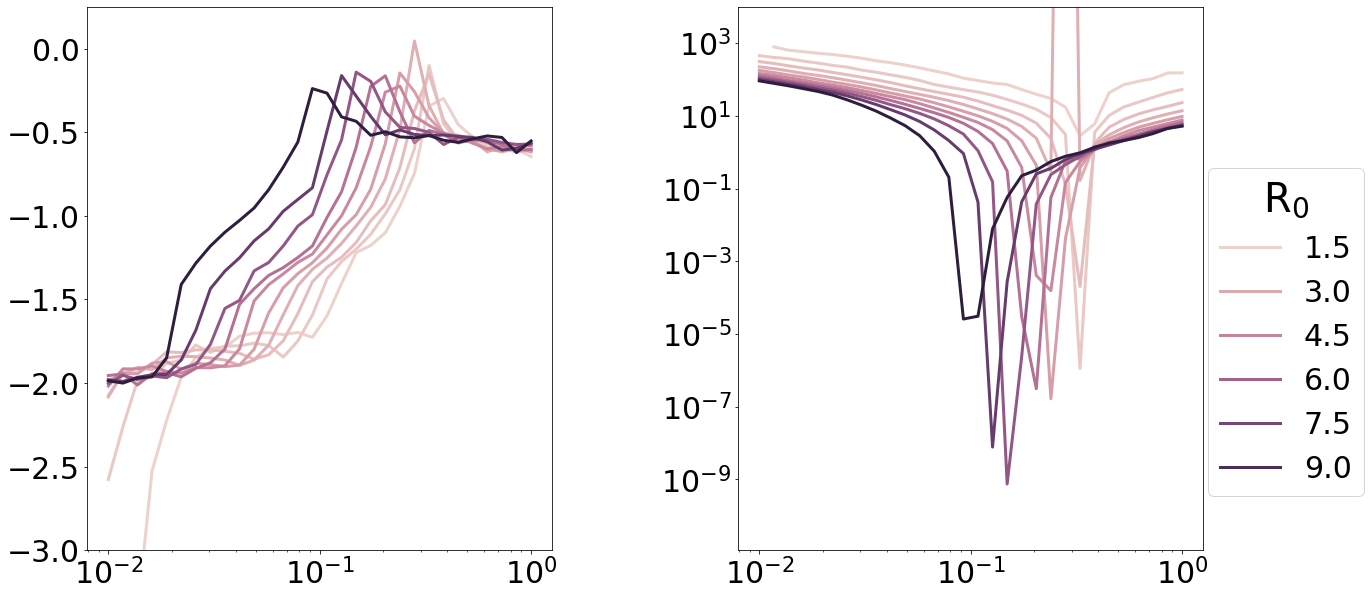

In [25]:
fit_params = np.array(fit_params)
fig,ax= plt.subplots(1,2,figsize=(20,10))
plt.subplots_adjust(wspace=0.4)
sns.lineplot(data=exponents_dataframe, x='scaled_dbar', y='alpha', ax=ax[0], hue= 'R0',legend = False)
sns.lineplot(data=exponents_dataframe, x='scaled_dbar', y='kappa_star', ax=ax[1], hue= 'R0')

for a in ax:
    a.set_xscale('log')
    # a.set_yscale('log')
    # a.set_xlim(right =.1)

    a.set_xlabel(r'')
    a.set_ylabel(r'')
    # a.set_xlabel(r'$\frac{\langle d \rangle}{\xi}$')
ax[1].set_yscale('log')
ax[0].set_ylim(bottom=-3,top=.25)
ax[1].legend(title=r'$R_0$', loc=(1.01,0.1), fontsize=30)
ax[1].set_ylim(top=1e4)
# plt.savefig(os.getcwd()+f'/figures/phase_diagram_plaw_alpha_kappastar.pdf', bbox_inches='tight')

In [26]:
fit_params = np.array(fit_params)

(1.127138741977637e-11, 10000.0)

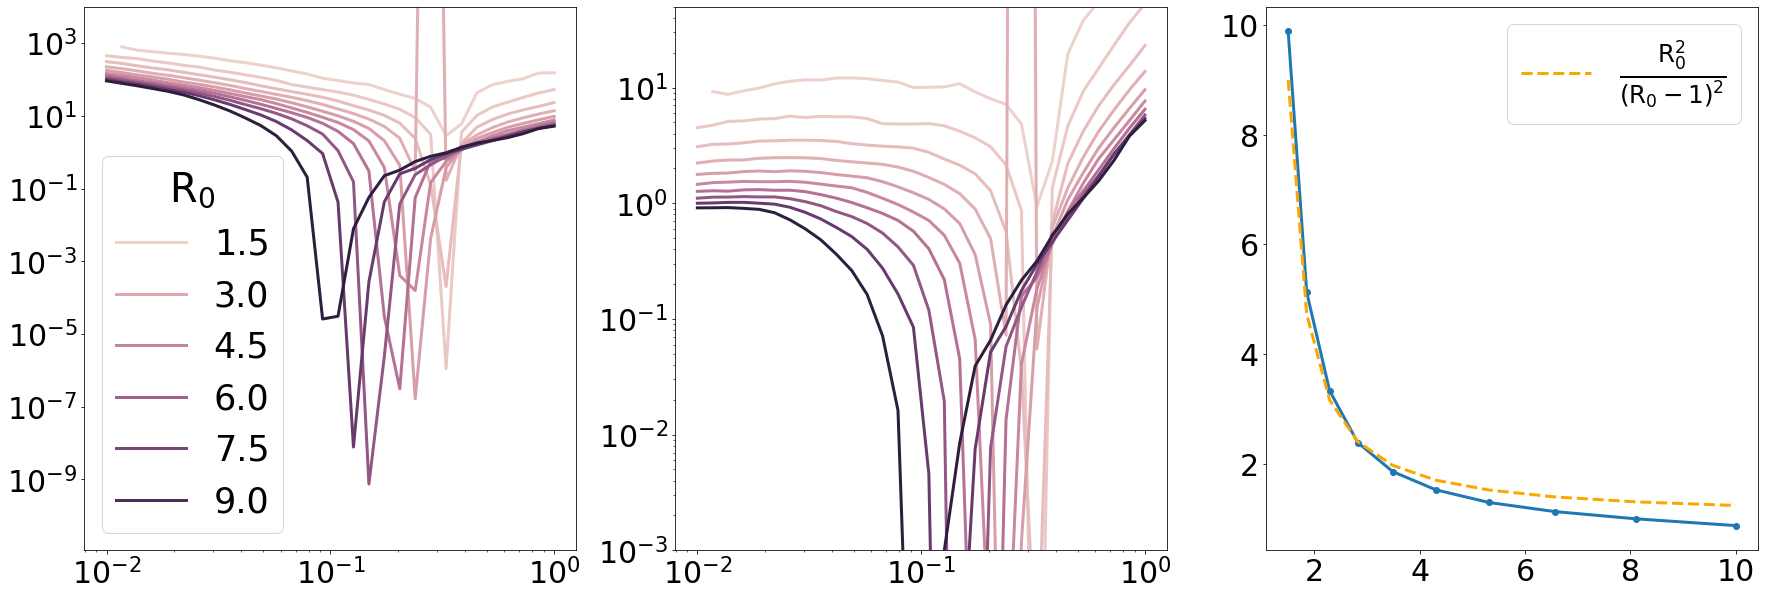

In [30]:
fit_params = np.array(fit_params)
fig,ax= plt.subplots(1,3,figsize=(30,10))
plt.subplots_adjust(wspace=0.2)
sns.lineplot(data=exponents_dataframe, x='scaled_dbar', y='kappa_star', ax=ax[0], hue= 'R0')
sns.lineplot(data=exponents_dataframe, x='scaled_dbar', y='kappa_times_delta', ax=ax[1], hue= 'R0',legend = False)

r_R0 = exponents_dataframe.query('scaled_dbar<3e-2').groupby('R0').mean()['kappa_times_delta']
ax[2].plot(R0s, r_R0, marker='o')
# ax[2].plot(R0s, 5/(R0s-1), color='black', linestyle='--',label = r'$\frac{5}{R_0-1}$')
ax[2].plot(R0s,   R0s**2/(R0s-1)**2, color='orange', linestyle='--',label = r'$\frac{R_0^2}{(R_0-1)^2}$')
# ax[2].plot(R0s,   R0s/(R0s-1), color='green', linestyle='--',label = r'$\frac{R_0}{(R_0-1)}$')
ax[2].legend(loc='best')


for a in ax[:2]:
    a.set_xscale('log')
    # a.set_yscale('log')
    # a.set_xlim(right =.1)

    a.set_xlabel(r'')
    a.set_ylabel(r'')
    # a.set_xlabel(r'$\frac{\langle d \rangle}{\xi}$')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(bottom=1e-3,top=5e1)
ax[0].legend(title=r'$R_0$')

# ax[0].legend(title=r'$R_0$', loc=(1.01,0.1), fontsize=30)
ax[0].set_ylim(top=1e4)
# plt.savefig(os.getcwd()+f'/figures/phase_diagram_plaw_kappastar_kappatimesdelta.svg', bbox_inches='tight')

/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/dtrimcev/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


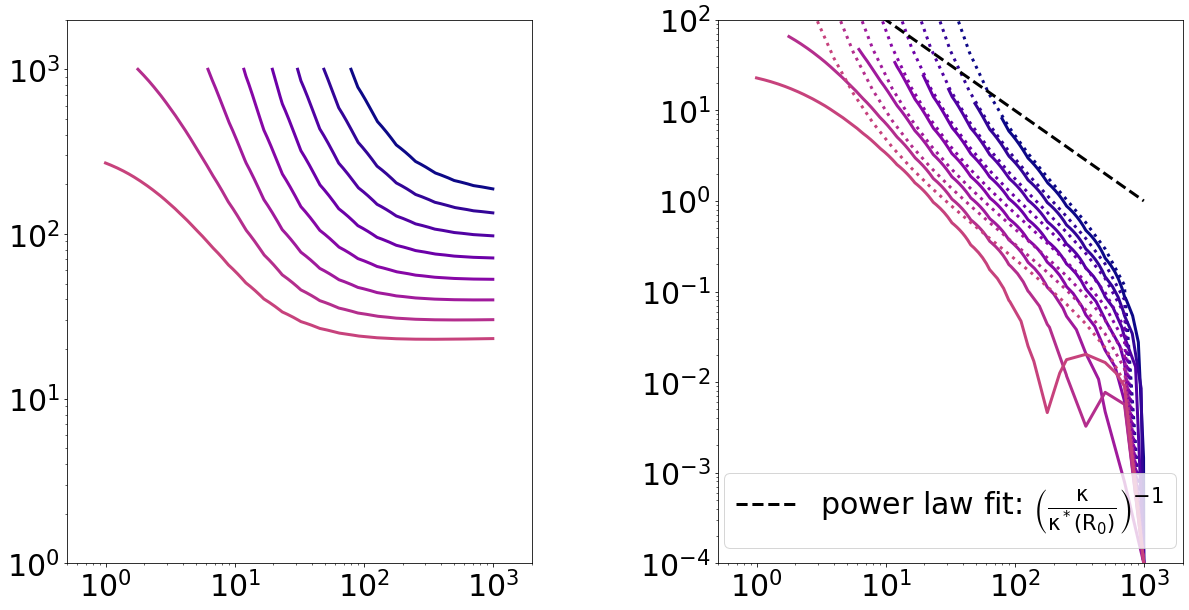

In [31]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.4)

    delta_s_from_df = evolution_pd['scaled_dbar'].unique()
    for scaled_dbar in delta_s_from_df[delta_s_from_df<.1][::2]:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())


        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
    
        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        ax[0].plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
        rescaled_Cy = Cy*scaled_dbar
        altlaw= R0/(R0-1) * (np.power(1 + R0/((R0-1)*kappa_s),(1-scaled_dbar)/scaled_dbar)-1)
        rescaled_Cy = np.abs(rescaled_Cy - rescaled_Cy[-1]+1e-4)
        ax[1].plot(Cx, rescaled_Cy, color=colors_scaled_dbar[scaled_dbar])#, label = rf'${scaled_dbar:.2e}$')

        #fit Cx, rescaled_Cy to power law
        try:
            fit = np.polyfit(np.log(Cx), np.log(rescaled_Cy), 1)
            fit_fn = np.poly1d(fit)

            altlaw= R0/(R0-1) * (np.power(1 + R0/((R0-1)*kappa_s),(1-scaled_dbar)/scaled_dbar)-1)
            ax[1].plot(kappa_s, altlaw - altlaw[-1]+1e-4, color=colors_scaled_dbar[scaled_dbar], linestyle=':')
        except LinAlgError:
            continue            
        # 
    # ylim = ax[1].get_ylim()
    ax[1].plot(kappa_vals, 1e3/(kappa_vals), color='black', linestyle='--', label =r'power law fit: $ \left(\frac{\kappa}{\kappa^*\left(R_0\right)}\right)^{-1}$')
    # ax[1].set_ylim(ylim)
    ax[0].set_xlim(ax[0].get_xlim()*np.array([.5,2]))
    ax[1].set_xlim(ax[0].get_xlim())
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel(r'')
    ax[0].set_ylabel(r'')
    ax[1].set_xlabel(r'')
    ax[1].set_ylabel(r'')
    ax[1].legend(loc='lower center', fontsize=30)
    ax[1].set_xscale('log')
    ylogged = True 

    if ylogged:
        ax[1].set_yscale('log')

    ax[0].set_ylim((1,2e3))
    # ax[1].set_ylim((1,90))

    ax[1].set_ylim((1e-4,1e2))

In [32]:
def get_label_in_exponential_form(lab):
    # print(float(lab.replace('$','')))
    exponent = np.floor(np.log10(float(lab.replace('$',''))))
    mantissa = float(lab.replace('$',''))/10**exponent

    return f'${mantissa:.2f}\cdot 10^{{{exponent:.0f}}}$'

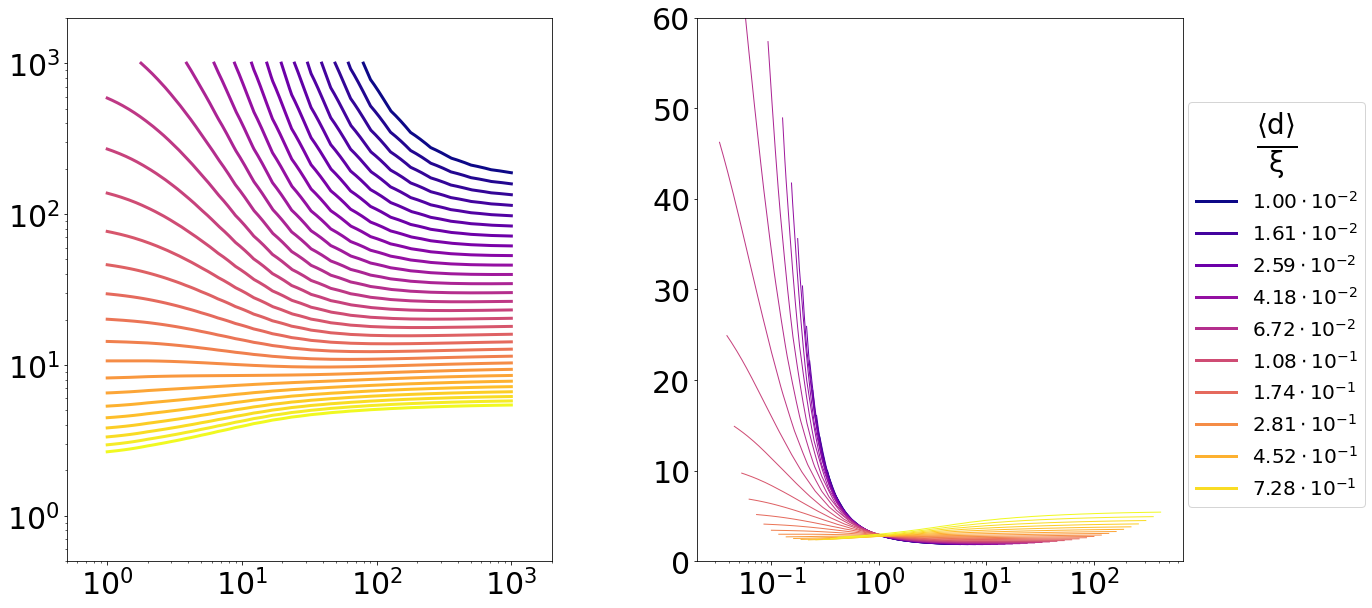

In [34]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)
delta_s_from_df = evolution_pd['scaled_dbar'].unique()
for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.3)
    
    for scaled_dbar in delta_s_from_df:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        ax[0].plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
        
        rescaled_Cy = Cy*scaled_dbar
        kstar = (R0/(R0-1))**2 /scaled_dbar
        rescaled_Cx = Cx/kstar
        ax[1].plot(rescaled_Cx, rescaled_Cy , color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$',lw=1)

    ax[0].set_xlim(ax[0].get_xlim()*np.array([.5,2]))
    ax[0].set_ylim(ax[0].get_ylim()*np.array([.5,2]))
    

    for xi in xi_s:
        delta = dbar/xi
        
        p_alpha= 1/dbar
        exp_val_kappa_inf = mu*N/(xi*p_alpha) * ((R0-1)/R0)**2 /2 # exp must be log 2
        exp_val_kappa0 = mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) # exp must be log 2

        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha))
        equal_proba_point_kappa_inf = np.log(2)/(((R0-1)/R0)**2 /2)*(xi*p_alpha)

    handles, labels= ax[0].get_legend_handles_labels()
    handles = handles[::3]
    labels = labels[::3]
    labels = [get_label_in_exponential_form(lab) for lab in labels]

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel(r'')
    ax[0].set_ylabel(r'')
    ax[1].set_xlabel(r'')
    ax[1].set_ylabel(r'')
    ax[1].set_xscale('log')
    ylogged = False

    if ylogged:
        ax[1].set_yscale('log')

        ax[1].set_ylim(ax[1].get_ylim()*np.array([.5,2]))
    else:
        ax[1].set_ylim((0,60))

    ax[1].legend(handles,labels, title= r'$\frac{\langle d\rangle}{\xi}$',loc=(1.01,0.1), fontsize=20)
    # os.makedirs(os.getcwd()+'/figures', exist_ok=True)
    # plt.savefig(os.getcwd()+f'/figures/phase_diagram_mountain_logy{ylogged}.svg', bbox_inches='tight')

In [189]:
R0

2.8231080866430855

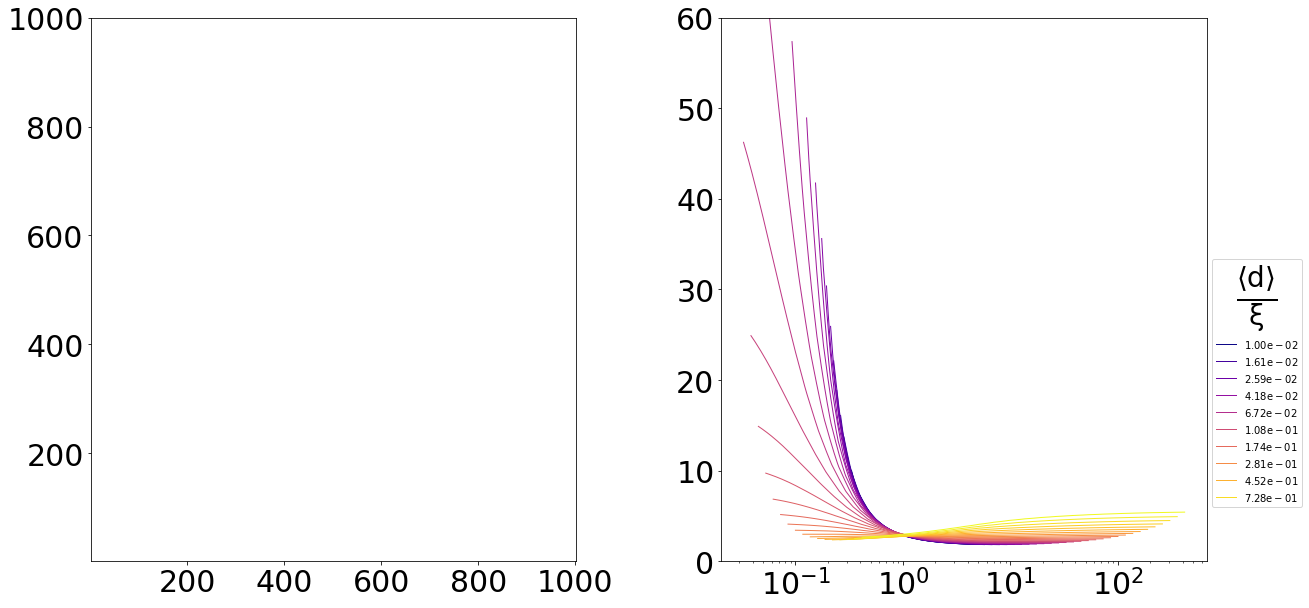

In [36]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)
delta_s_from_df = evolution_pd['scaled_dbar'].unique()
for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.3)
    
    for scaled_dbar in delta_s_from_df:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        
        rescaled_Cy = Cy*scaled_dbar
        kstar = (R0/(R0-1))**2 /scaled_dbar
        rescaled_Cx = Cx/kstar
        ax[1].plot(rescaled_Cx, rescaled_Cy , color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$',lw=1)
    # ax[1].set_xlim(ax[0].get_xlim()
    handles, labels= ax[1].get_legend_handles_labels()

    for xi in xi_s:
        delta = dbar/xi
        
        p_alpha= 1/dbar
        exp_val_kappa_inf = mu*N/(xi*p_alpha) * ((R0-1)/R0)**2 /2 # exp must be log 2
        exp_val_kappa0 = mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) # exp must be log 2

        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha))
        equal_proba_point_kappa_inf = np.log(2)/(((R0-1)/R0)**2 /2)*(xi*p_alpha)
        # p_evo_kappa0 = 1- np.exp(-mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) )

    handles = handles[::3]
    labels = labels[::3]
    ax[1].set_xlabel(r'')
    ax[1].set_ylabel(r'')
    ax[1].set_xscale('log')
    ylogged = False

    if ylogged:
        ax[1].set_yscale('log')

        ax[1].set_ylim(ax[1].get_ylim()*np.array([.5,2]))
    else:
        ax[1].set_ylim((0,60))
    # ax[0].set_ylim((1,2e3))
    # ax[1].set_ylim((1,90))

    ax[1].legend(handles,labels, title= r'$\frac{\langle d\rangle}{\xi}$',loc=(1.01,0.1), fontsize=10)
    # os.makedirs(os.getcwd()+'/figures', exist_ok=True)
    # plt.savefig(os.getcwd()+f'/figures/phase_diagram_mountain_logy{ylogged}.svg', bbox_inches='tight')

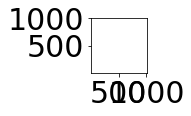

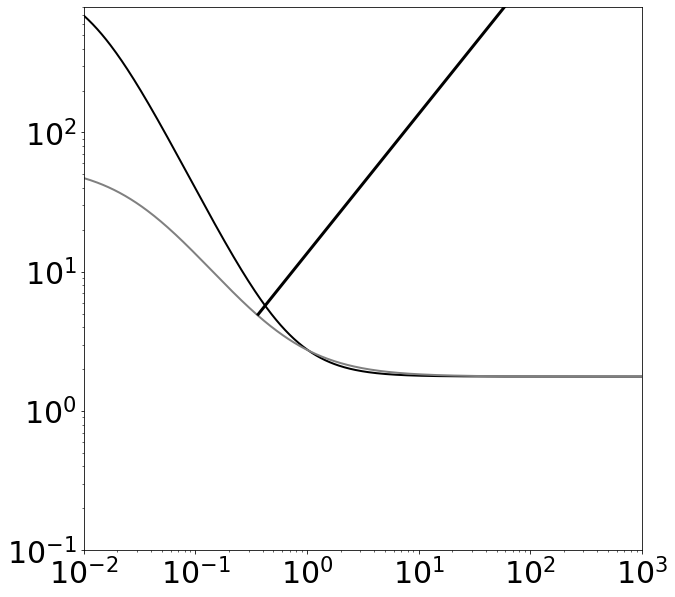

In [39]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)
delta_s_from_df = evolution_pd['scaled_dbar'].unique()
fig_ghost,ax_ghost = plt.subplots(1,1,figsize=(1,1))

for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,1,figsize=(10,10))
    plt.subplots_adjust(wspace=0.3)
    
    for i_d, scaled_dbar in enumerate(delta_s_from_df[np.array([12, 16])]):
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())
        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
        C =ax_ghost.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        rescaled_Cy = Cy*scaled_dbar
        rescaled_Cy_subtracted = np.abs(rescaled_Cy - rescaled_Cy[-1]+1e-4)
    
        #fit Cx, rescaled_Cy to power law
        try:
            fit = np.polyfit(np.log(Cx[:-1]), np.log(rescaled_Cy_subtracted)[:-1], 1)
            fit_fn = np.poly1d(fit)
            exponent = fit_fn[1] 
        except LinAlgError:
            continue   

        kstar = (R0/(R0-1))**2 /scaled_dbar
        rescaled_Cx = Cx/kstar
        xs= np.logspace(-2,3,500)
        z_inf_inf = (R0-1)/R0
        if i_d ==0:
            color= 'k'
        else:
            color='grey'

        equal_proba_point_kappa_inf = np.log(2)/((-z_inf_inf-np.log(1-z_inf_inf)))#*delta_s_from_df)
        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-1/scaled_dbar))
        law = equal_proba_point_kappa_inf + (equal_proba_point_kappa0-equal_proba_point_kappa_inf)/( 1+  (equal_proba_point_kappa0-equal_proba_point_kappa_inf) *xs**(-exponent))
        ax.plot(xs, law , color=color, linestyle='-',lw=2)
    early_late_law =  2* R0**3/(R0-1)**2 * xs
    ax.plot(xs[early_late_law>=law],early_late_law[early_late_law>=law],color='black')

    ax.set_xscale('log')
    ylogged = True

    if ylogged:
        ax.set_yscale('log')
        ax.set_ylim(np.array([1e-1,8e2]))
        ax.set_xlim(np.array([1e-2,1e3]))
    else:
        ax.set_ylim((0,60))

plt.savefig(output_folder+'/fig2.svg', bbox_inches='tight')


In [118]:
30*9/4

67.5

In [62]:
fit_fn[1]

-1.3729149279928896

In [26]:
#turn warnings off
import warnings

warnings.filterwarnings('ignore')

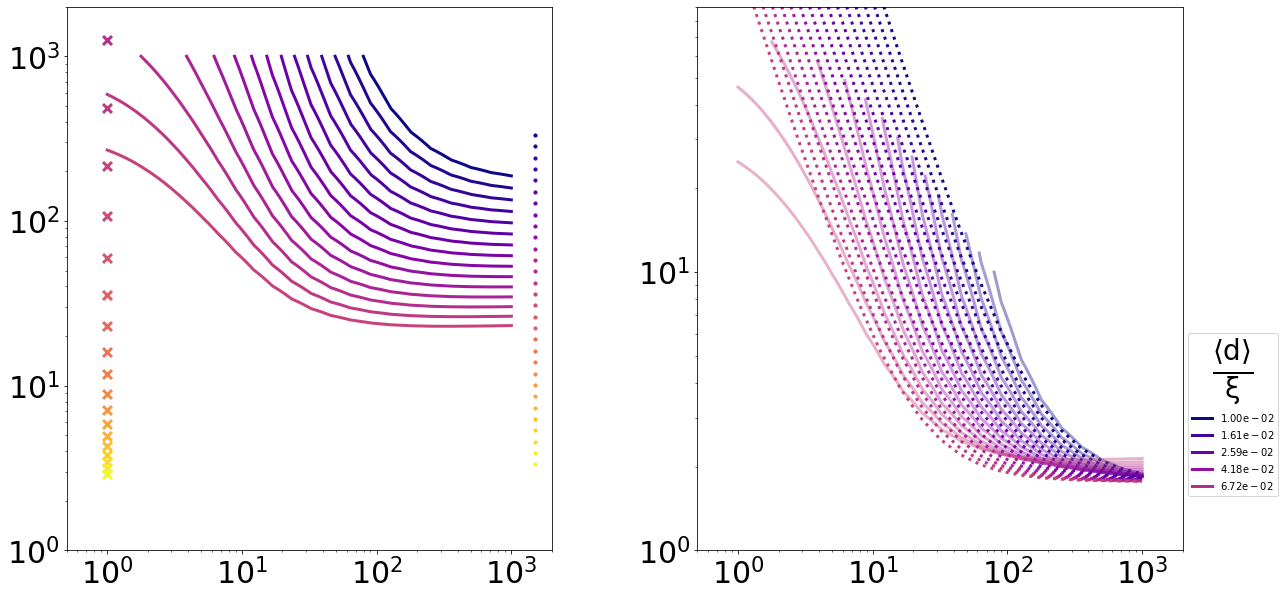

In [127]:
# delta_s_from_df = evolution_pd['scaled_dbar'].unique()
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.plasma)

for R0 in [R0s[3]]:
    fig,ax= plt.subplots(1,2,figsize=(20,10))
    plt.subplots_adjust(wspace=0.3)

    
    for scaled_dbar in delta_s_from_df[delta_s_from_df<.1]:
        mini_df = (evolution_pd
            .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
            .groupby(['kappa_plot', 'muN'])
            .mean()
            .reset_index())


        muN_vals = mini_df['muN'].unique()
        kappa_vals = mini_df['kappa_plot'].unique()
        p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values

        C =ax[0].contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
        Cx, Cy = C.allsegs[0][0].T
        ax[0].plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$')
        ax[1].plot(Cx, Cy*scaled_dbar, color=colors_scaled_dbar[scaled_dbar], label = rf'${scaled_dbar:.2e}$',alpha=.4)
        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-1/scaled_dbar))
        z_inf_inf= (R0-1)/R0
        equal_proba_point_kappa_inf = np.log(2)/((-z_inf_inf-np.log(1-z_inf_inf))*scaled_dbar)

        dMuN_inf = scaled_dbar*equal_proba_point_kappa_inf
        k_star = 1/scaled_dbar * (R0/(R0-1))**2
        dMuN_k = dMuN_inf + (kappa_s/k_star)**(-1.5)

        ax[1].plot(kappa_s, dMuN_k,linestyle = ':', color=colors_scaled_dbar[scaled_dbar])

    ax[0].set_xlim(ax[0].get_xlim()*np.array([.5,2]))
    ax[1].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim()*np.array([.5,2]))
    ax[1].set_ylim(ax[1].get_ylim()*np.array([.5,2]))

    for xi in xi_s:
        delta = dbar/xi
        
        p_alpha= 1/dbar
        exp_val_kappa_inf = mu*N/(xi*p_alpha) * ((R0-1)/R0)**2 /2 # exp must be log 2
        exp_val_kappa0 = mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) # exp must be log 2

        equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha))
        equal_proba_point_kappa_inf = np.log(2)/(((R0-1)/R0)**2 /2)*(xi*p_alpha)
        # p_evo_kappa0 = 1- np.exp(-mu*N*np.log(R0)/(R0)*np.power(R0/(R0-1),-xi*p_alpha) )
        ax[0].scatter(1,equal_proba_point_kappa0, marker='x', color=colors_scaled_dbar[delta],s=80)
        ax[0].scatter(1.5*kappa_s[-1] ,equal_proba_point_kappa_inf, s=10, marker='o',color=colors_scaled_dbar[delta])


    handles, labels= ax[0].get_legend_handles_labels()
    handles = handles[::3]
    labels = labels[::3]


    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel(r'')
    ax[0].set_ylabel(r'')
    ax[1].set_xlabel(r'')
    ax[1].set_ylabel(r'')

    ax[1].set_xscale('log')
    ylogged = True 

    if ylogged:
        ax[1].set_yscale('log')

    ax[0].set_ylim((1,2e3))
    ax[1].set_ylim((1,90))

    ax[1].legend(handles,labels, title= r'$\frac{\langle d\rangle}{\xi}$',loc=(1.01,0.1), fontsize=10)

(1, 2000.0)

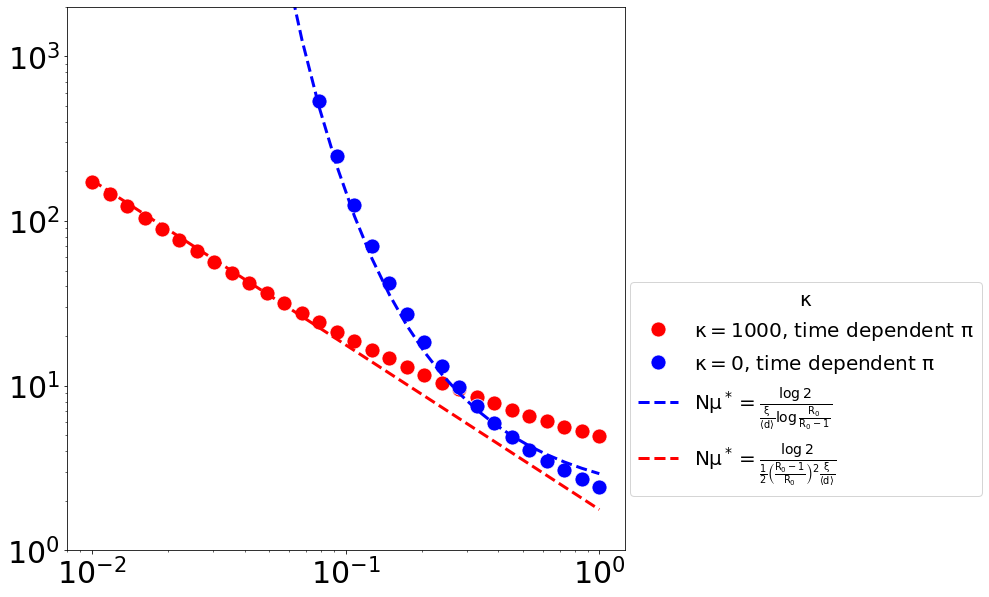

In [30]:
R0 = R0s[3]
p_50_m = .42
p_50_M = .52
fig,ax = plt.subplots(1,figsize=(10,10))
sns.lineplot(data=evolution_pd
             .query(f'R0=={R0} & kappa=={kappa_s[-1]} & p_evo>{p_50_m} & p_evo<{p_50_M}'), x='scaled_dbar', y='muN', palette=colors_scaled_dbar, linestyle='',marker='o',ms=15, label = fr'$\kappa={kappa_s[-1]:.0f}$, time dependent $\pi$', color= 'red',err_style=None)
sns.lineplot(data=evolution_pd
             .query(f'R0=={R0} & kappa=={kappa_s[0]} & p_evo>{p_50_m} & p_evo<{p_50_M}'), x='scaled_dbar', y='muN', palette=colors_scaled_dbar, linestyle='',marker='o',ms=15, label = fr'$\kappa={kappa_s[0]:.0f}$, time dependent $\pi$', color= 'blue',err_style=None)

# sns.lineplot(data=evolution_pd_adiabatic
#                 .query(f'R0=={R0} & kappa=={kappa_s[-1]} & p_evo>{p_50_m} & p_evo<{p_50_M}'), x='scaled_dbar', y='muN', palette=colors_scaled_dbar, linestyle='',marker='X',ms=15,color='red')

# sns.lineplot(data=evolution_pd_adiabatic
#                 .query(f'R0=={R0} & kappa=={kappa_s[0]} & p_evo>{p_50_m} & p_evo<{p_50_M}'), x='scaled_dbar', y='muN', palette=colors_scaled_dbar, linestyle='',marker='X',ms=15,color='blue')

equal_proba_point_kappa0 = np.log(2)/(np.log(R0)/(R0)*np.power(R0/(R0-1),-xi_s*p_alpha))

#summed =  ((-1 + E^(1/\[Xi])) (1 - p_alpha))/((1 - p_alpha) p_alpha (-1 + E^(1/\[Xi]) + p_alpha))
summed = lambda p_alpha, xi: ((-1 + np.exp(1/xi)) )/( p_alpha * (-1 + np.exp(1/xi)) + p_alpha)
summed_xis = np.array([summed(p_alpha=1/dbar, xi=xi) for xi in xi_s])
                              
equal_proba_point_kappa_inf = np.log(2)/((R0/(R0-1))**2 )*(xi_s*p_alpha)
z_inf_inf= (R0-1)/R0
int_z= -z_inf_inf - np.log(1-z_inf_inf)
equal_proba_point_kappa_inf = np.log(2)/((-z_inf_inf-np.log(1-z_inf_inf))*delta_s_from_df)

ax.plot(delta_s, equal_proba_point_kappa0, color='blue', linestyle='--', label = r'$N \mu^*=\frac{\log 2}{ \frac{\xi}{\langle d\rangle} \log \frac{R_0}{R_0-1}}$')
ax.plot(delta_s, equal_proba_point_kappa_inf, color='red', linestyle='--', label = r'$N \mu^*=\frac{\log 2}{\frac{1}{2}\left(\frac{R_0-1}{R_0}\right)^2 \frac{\xi}{\langle d\rangle}}$')

ax.legend(title= r'$\kappa$',loc=(1.01,0.1), fontsize=20, title_fontsize=20)

ax.set_xlabel(r'')
ax.set_ylabel(r'')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1,2e3))

# plt.savefig(os.getcwd()+f'/figures/phase_diagram_mountain_extremes.pdf', bbox_inches='tight')

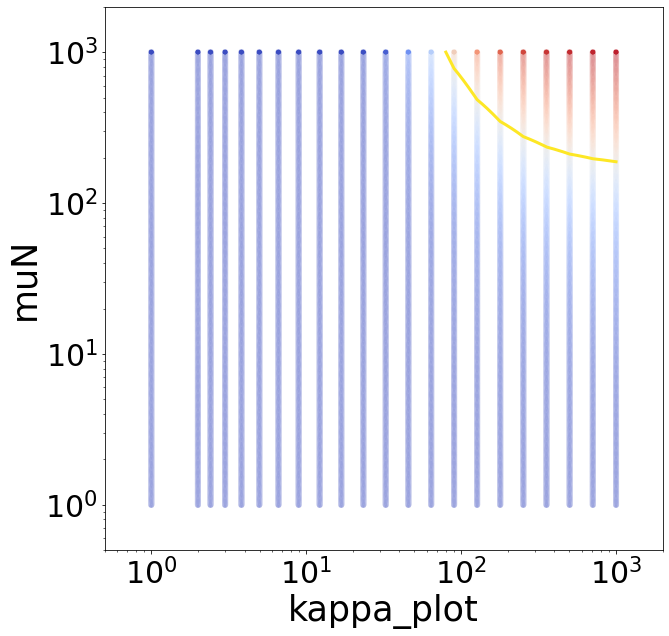

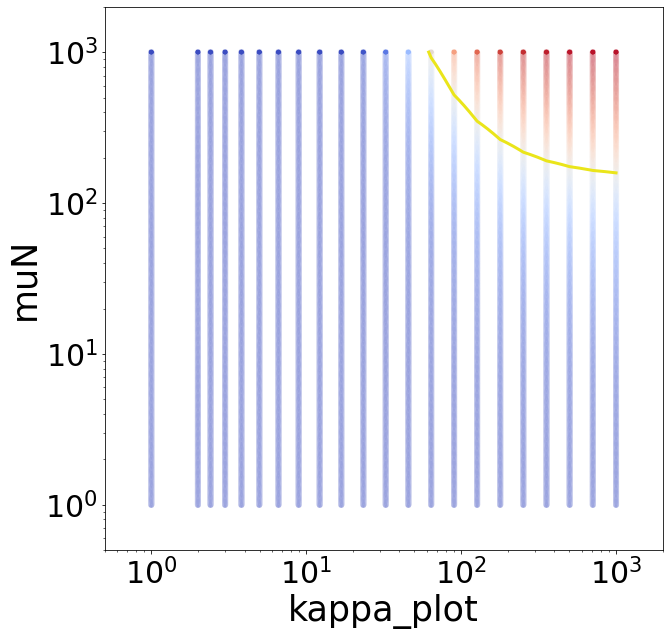

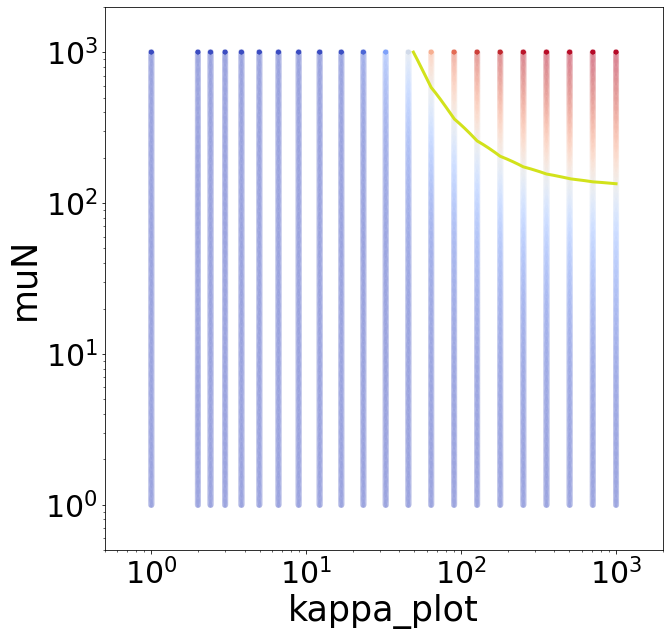

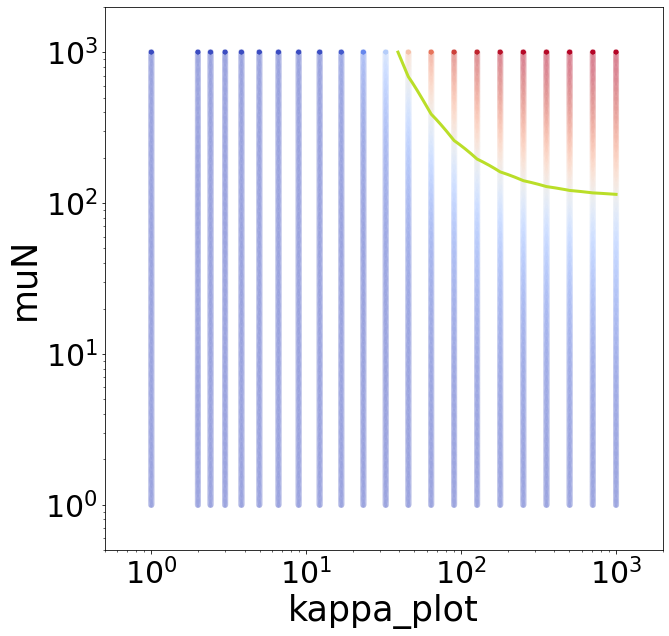

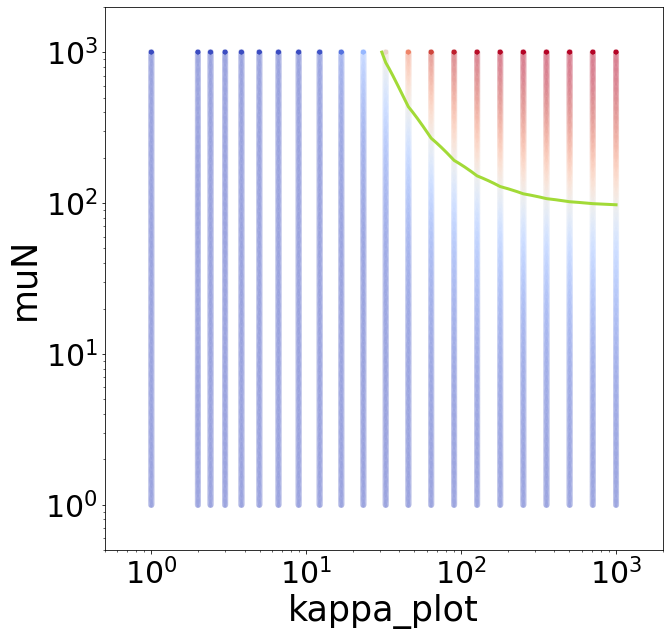

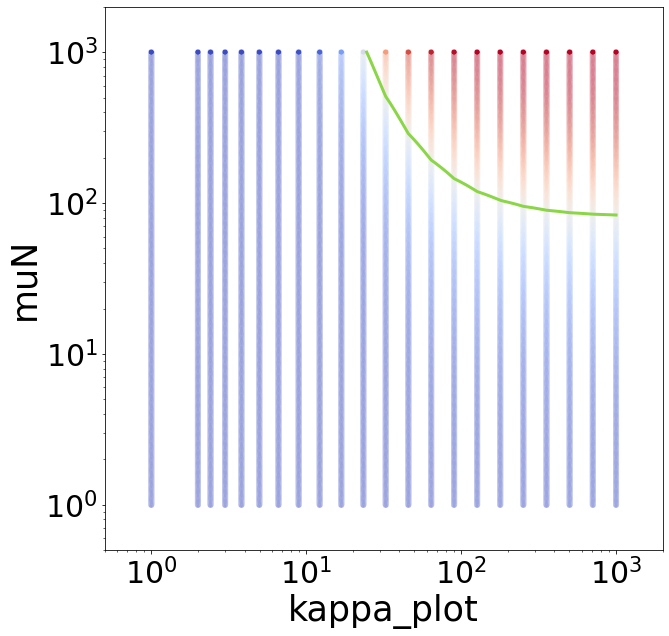

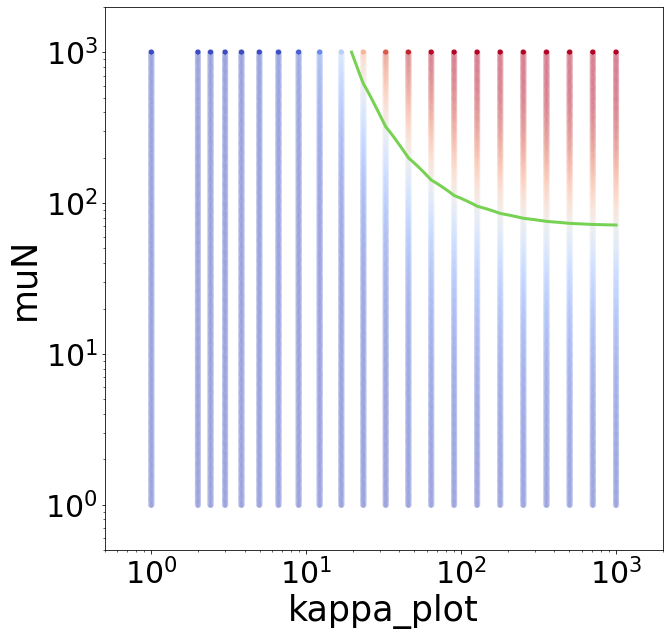

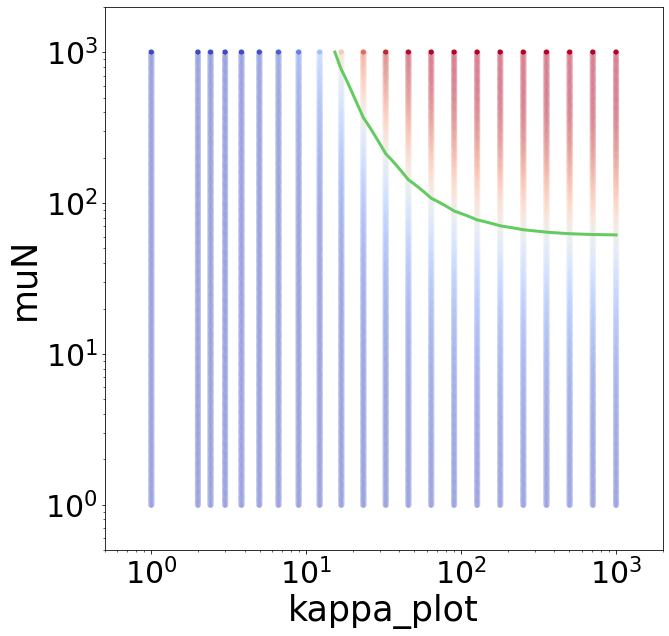

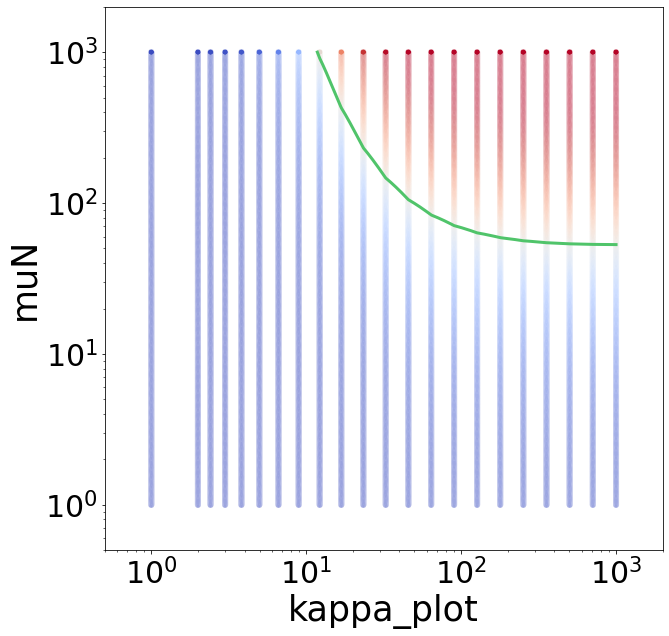

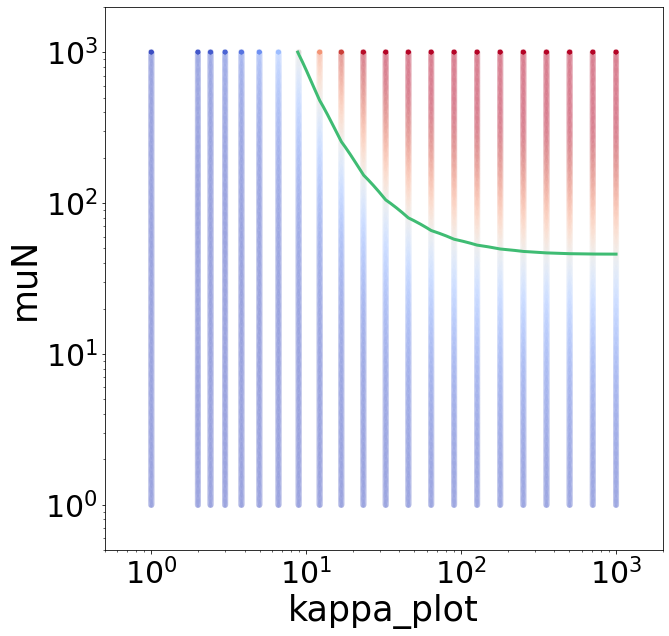

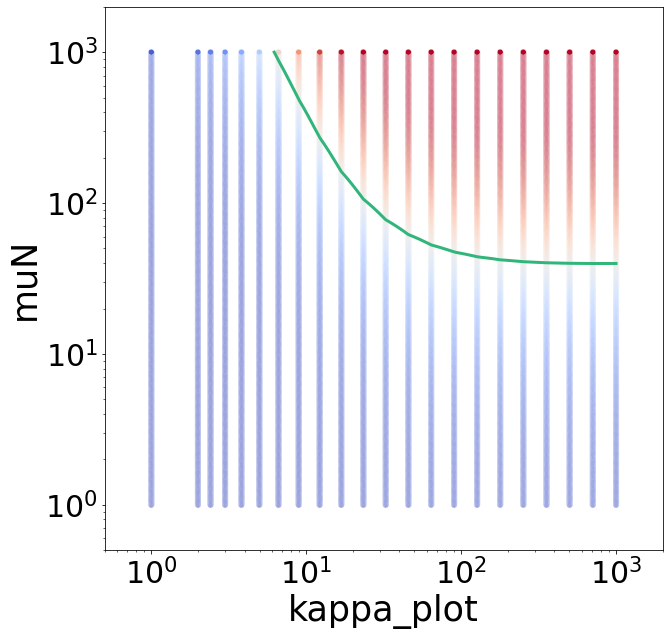

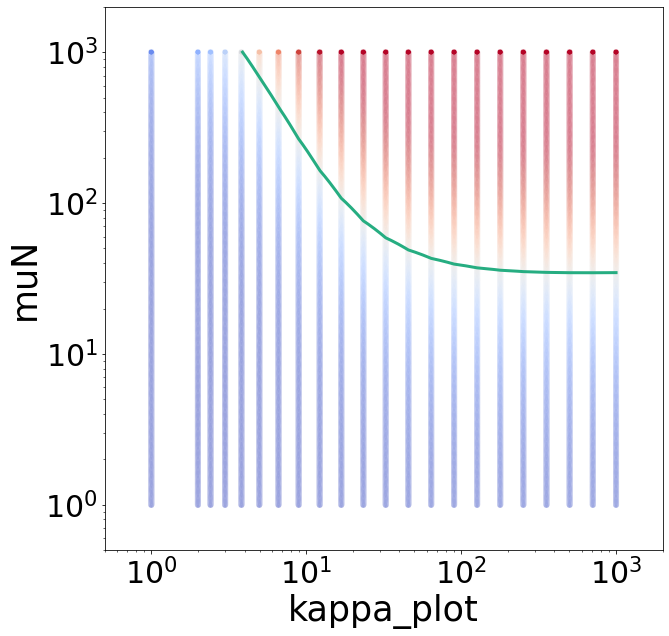

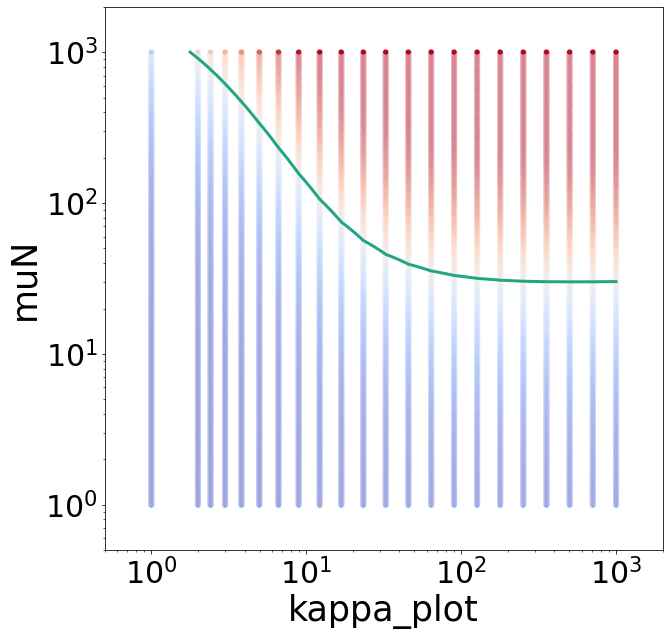

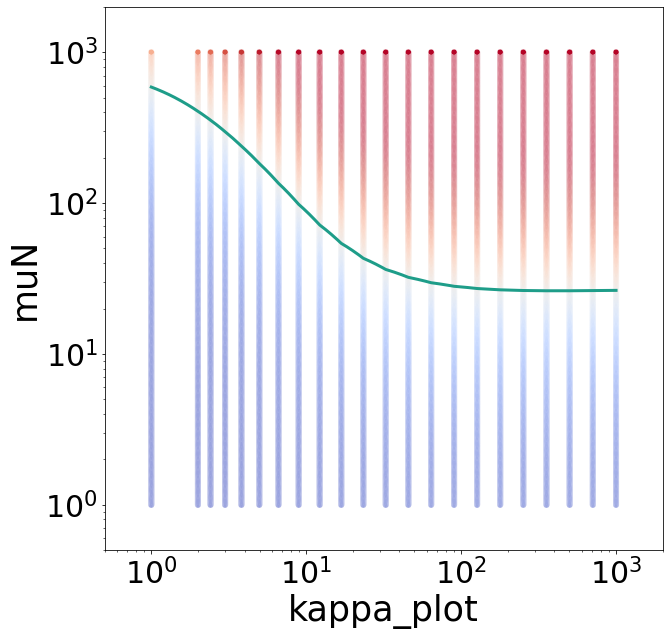

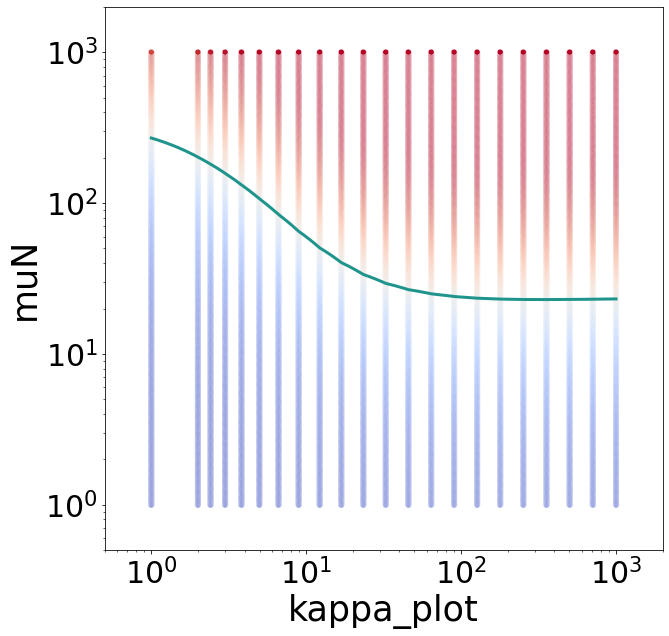

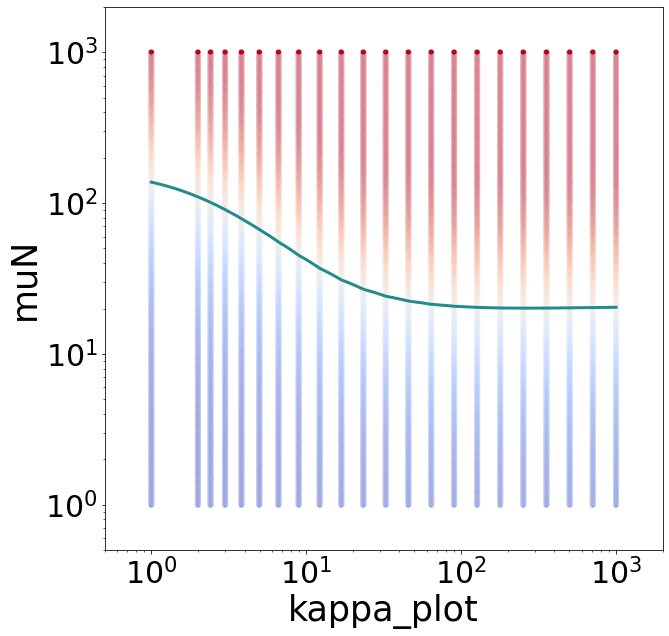

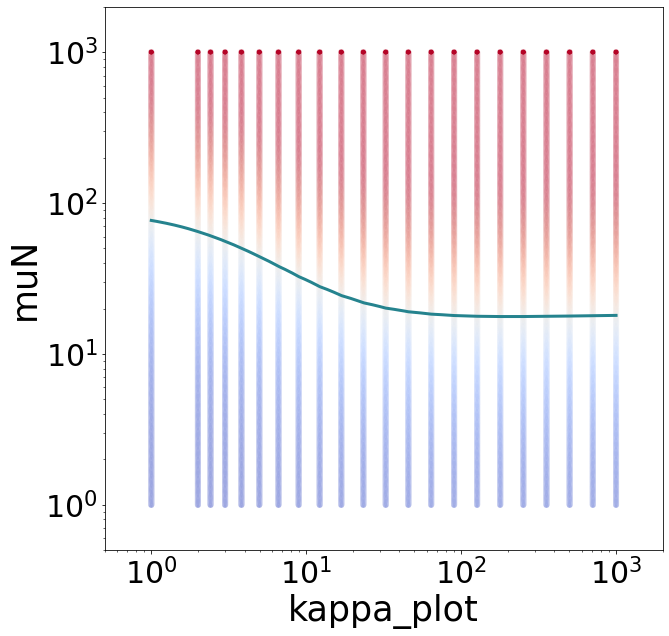

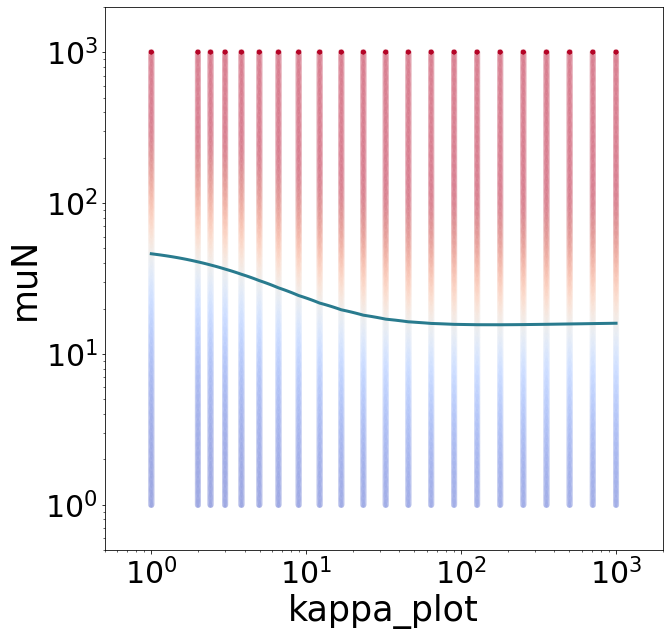

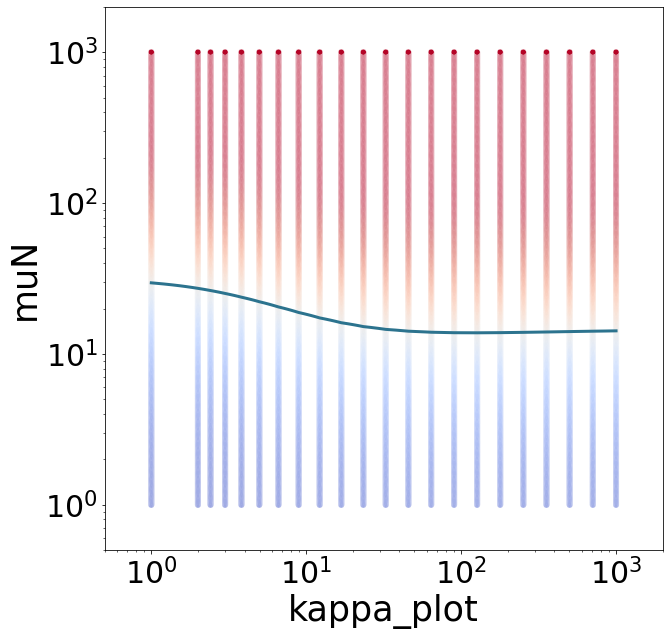

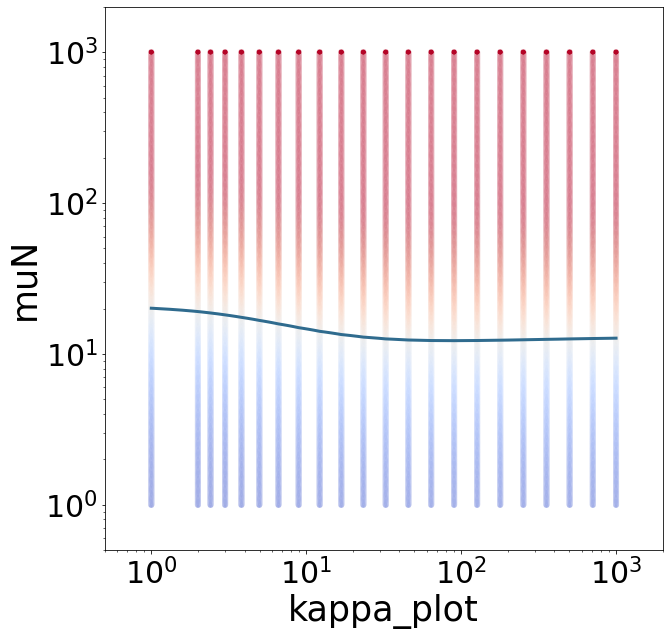

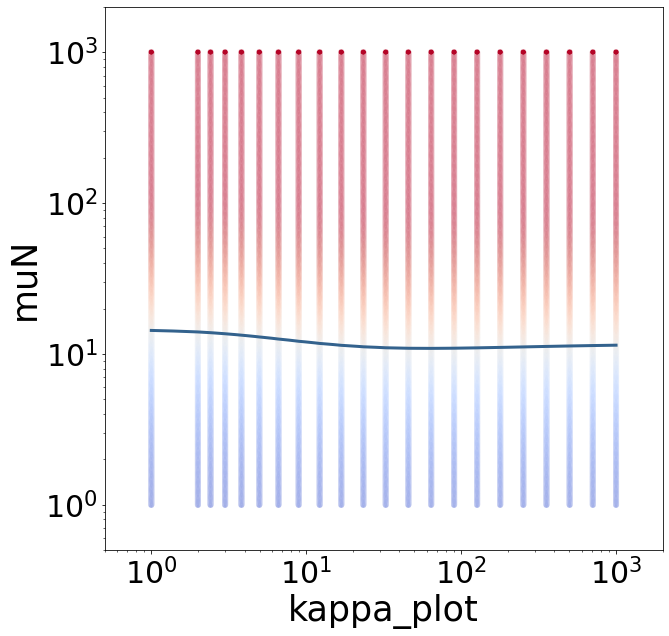

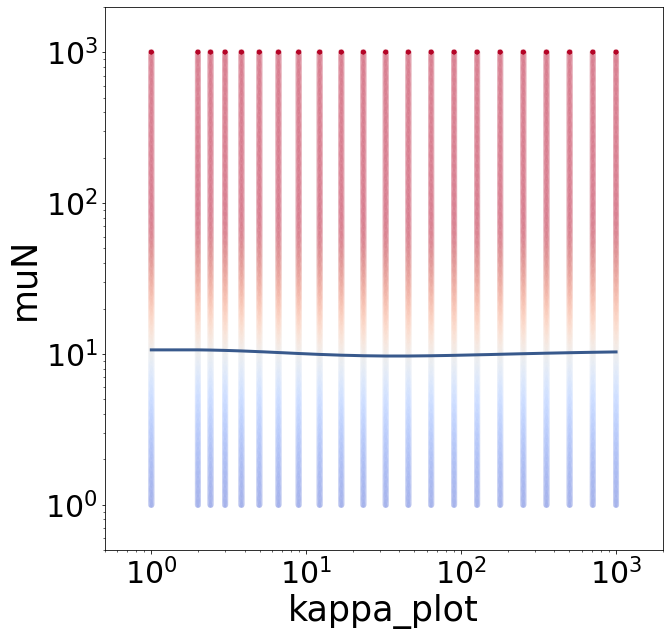

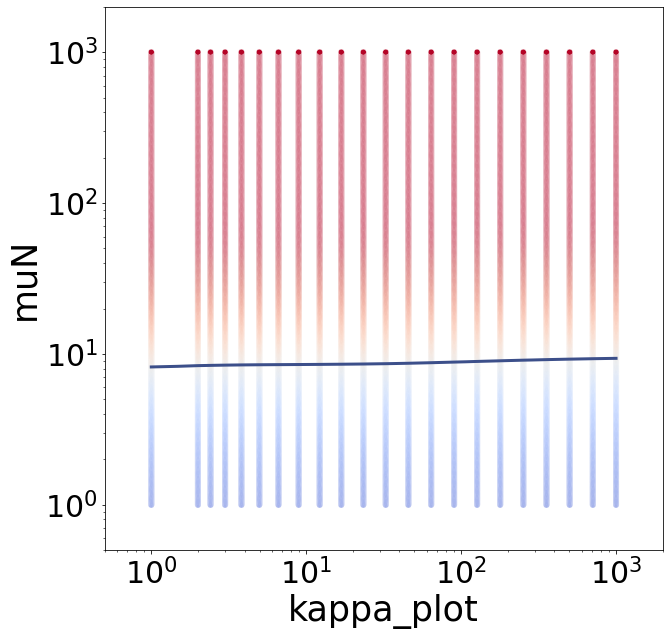

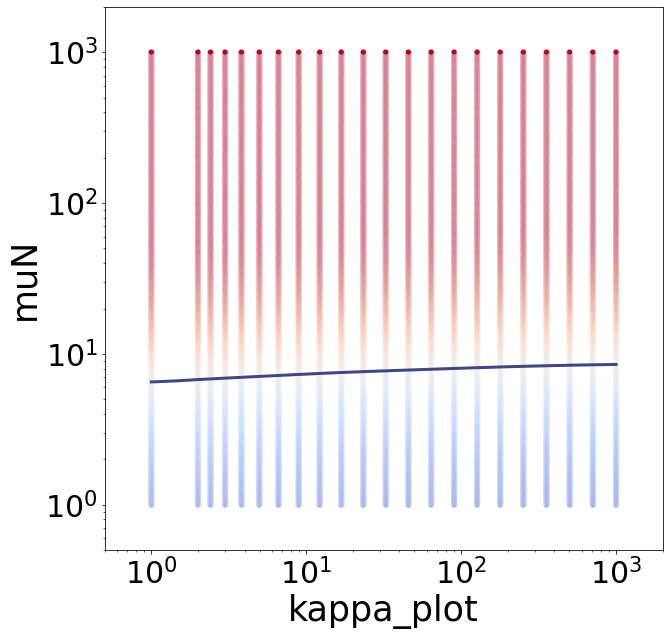

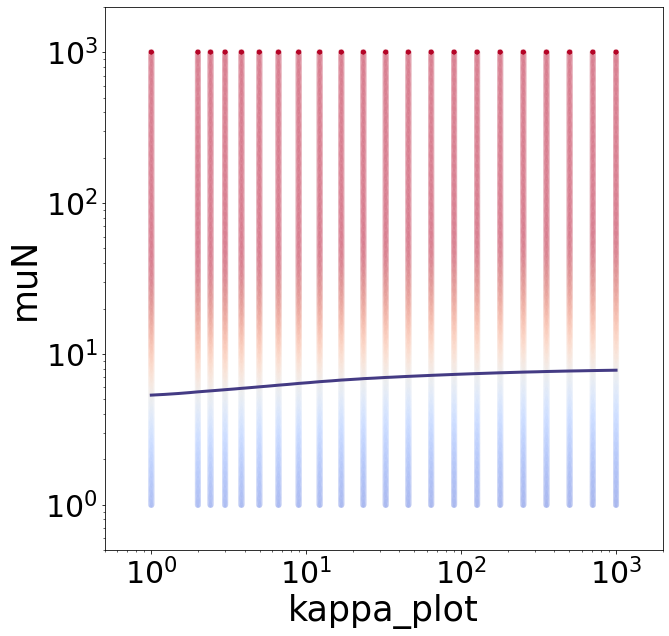

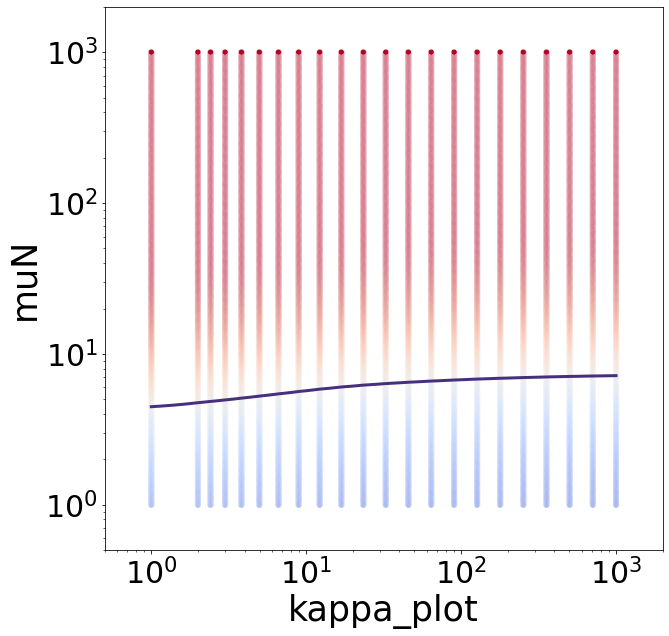

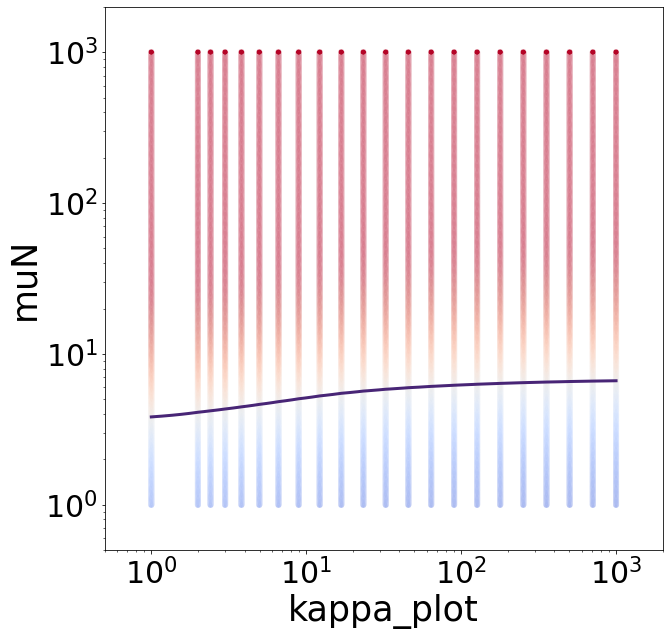

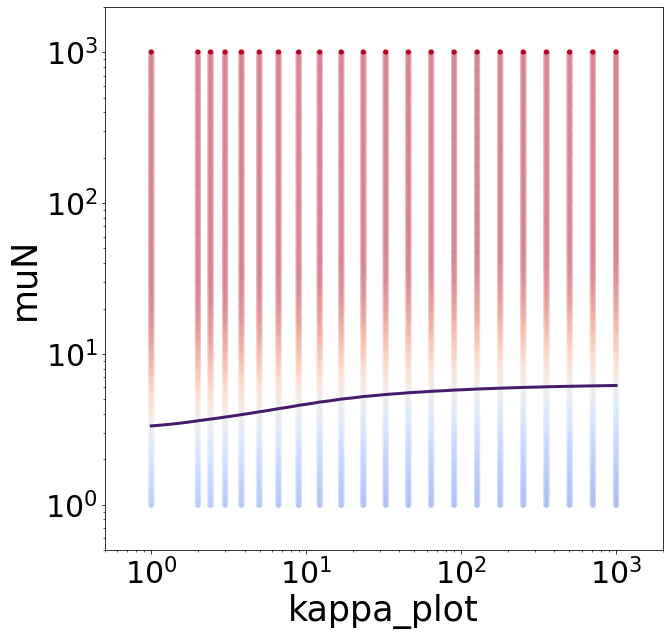

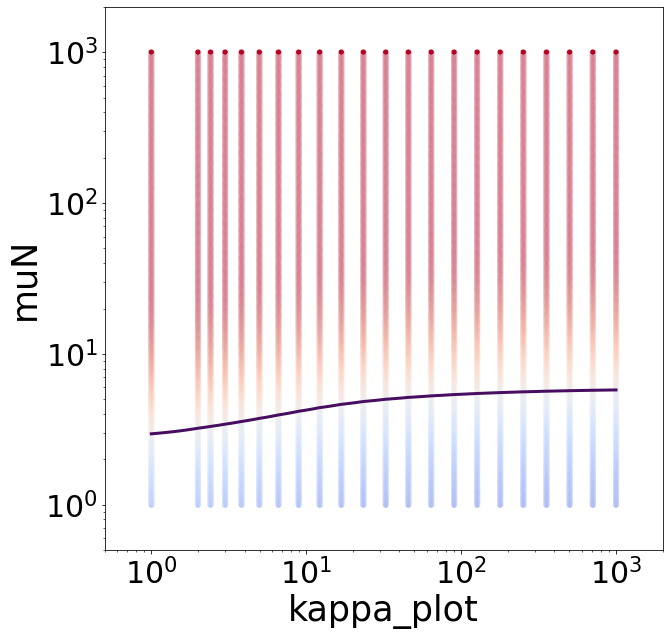

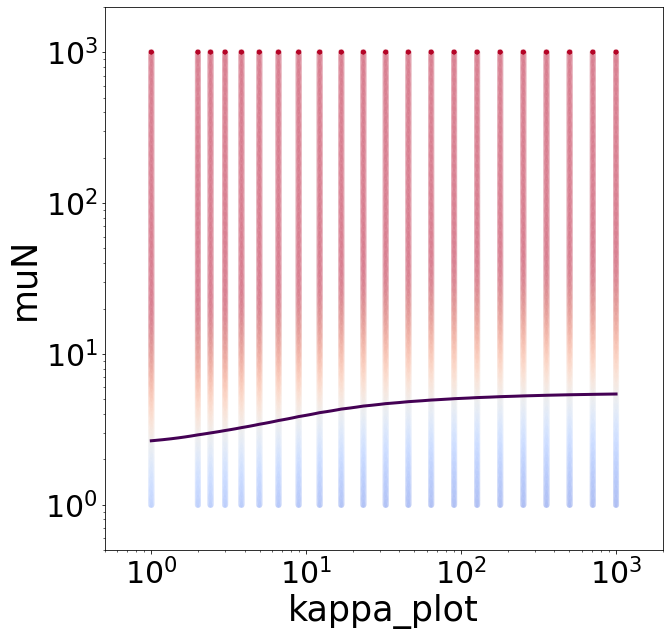

In [28]:
colors_scaled_dbar= funcs.color_dict(evolution_pd['scaled_dbar'].unique(),plt.cm.viridis_r)

for scaled_dbar in evolution_pd['scaled_dbar'].unique():
    fig,ax= plt.subplots(figsize=(10,10))
    mini_df = (evolution_pd
           .query(f'R0=={R0} and scaled_dbar=={scaled_dbar}')
           .groupby(['kappa_plot', 'muN'])
           .mean()
           .reset_index())


    muN_vals = mini_df['muN'].unique()
    kappa_vals = mini_df['kappa_plot'].unique()
    p_evo_vals = mini_df.pivot(index='muN', columns='kappa_plot', values='p_evo').values
    C =ax.contour(kappa_vals, muN_vals, p_evo_vals, levels=[0.5],alpha=0)
    Cx, Cy = C.allsegs[0][0].T
    ax.plot(Cx, Cy, color=colors_scaled_dbar[scaled_dbar], label = rf'$\bar{{d}}/\xi={scaled_dbar:.2f}$')

    #scatterplot with colors between 0 and 1
    sns.scatterplot(data=mini_df, x='kappa_plot', y='muN', ax=ax, hue='p_evo', palette='coolwarm', legend=False, zorder=0,hue_norm=(0,1))
    # sns.scatterplot(data=mini_df.query(' p_evo>.15'), x='kappa_plot', y='muN', ax=ax, palette=['red'], legend=False, zorder=0)             
    # ax[1].set_ylim(ylim)
    ax.set_xlim(ax.get_xlim()*np.array([.5,2]))
    ax.set_ylim(ax.get_ylim()*np.array([.5,2]))
    ax.set_yscale('log')
    ax.set_xscale('log')